In [2]:
# from pylpg import lpg_execution, lpgdata
# # Simulate the predefined household CHR01 (couple, both employed) for the year 2022
# data = lpg_execution.execute_lpg_single_household(
#         2022,
#     lpgdata.Households.CHR01_Couple_both_at_Work,
#     lpgdata.HouseTypes.HT21_Normal_House_with_15_000_kWh_Heat_Demand_Heat_Pump_with_COP3_and_Hot_Water_Storage_Tank_Heat_Pump_Electricity,
#     # resolution="01:00:00"
# )

In [3]:
# data.columns
# ['None_HH1', 'Inner Device Heat Gains_HH1', 'Reactive_House',
#        'Gas_House', 'Space Heating_House', 'Reactive_HH1', 'Electricity_HH1',
#        'Cold Water_House', 'Apparent_HH1', 'Hot water_HH1',
#        'Air Conditioning Load_House', 'Apparent_House',
#        'Inner Device Heat Gains_House', 'Hot water_House', 'Cold Water_HH1',
#        'Electricity_House', 'Warm Water_HH1', 'Person Count for  - High_HH1',
#        'Person Count for  - Outside_HH1', 'Person Count for  - Unknown_HH1',
#        'Person Count for  - Low_HH1']

# data.describe()

## BDEW method

$$
{T}_{d,l}^{ref}=\frac{{T}_{d,l}+0.5\,{T}_{d-1,l}^{amb}+0.25\,{T}_{d-2,l}^{amb}+0.125\,{T}_{d-3,l}^{amb}}{1+0.5+0.25+0.125}
$$

$$
{f}_{d,l}=\frac{A}{1+{\left(\frac{B\cdot ^\circ C}{{T}_{d,l}^{ref}-{T}_{0}}\right)}^{C}}+D+max\left\{\begin{array}{c}{m}_{space}\cdot {T}_{d,l}^{ref}{/}^{\circ }C+{b}_{space}\\ {m}_{water}\cdot {T}_{d,l}^{ref}{/}^{\circ }C+{b}_{water}\end{array}\right\},
$$

In [4]:
import pandas as pd
temps = pd.read_csv("data/canada/CA_provinces_temperatures.csv", index_col=0, parse_dates=True)
ontario_temp = temps["Ontario"]

ot_dm = ontario_temp.groupby(ontario_temp.index.dayofyear).mean()
ot_dm
T_ref = (ot_dm + 0.5 * ot_dm.shift(1) + 0.25 * ot_dm.shift(2) + 0.125 * ot_dm.shift(3) )/(1+0.5+0.25+0.125)
# T_ref.plot()

Text(0.5, 0, '$T^{ref}_{d,l}$ (°C)')

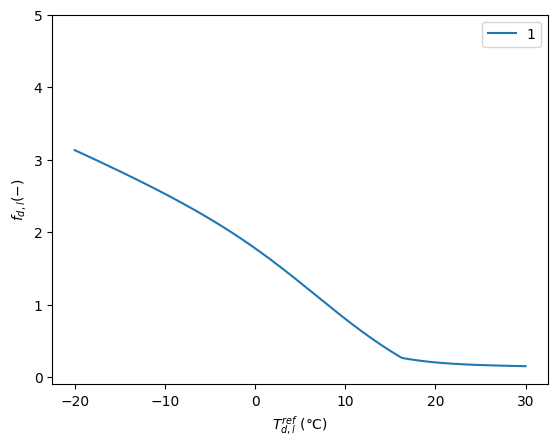

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams["text.usetex"] = False

A =   1.0443538
B = -35.0333754
C =   6.2240634
D =   0.0502917
T_0 = 40
m_H = -0.0535830
b_H = 0.9995901
m_W = -0.002176
b_W = 0.16332

@np.vectorize
def f_dl(T_ref):
    first_term = A/(1+(B/(T_ref-T_0))**C) +D
    second_term = max((m_H*T_ref + b_H), (m_W*T_ref + b_W))
    return first_term + second_term

outdoor_t = np.linspace(-20,30,1000)

fdl = f_dl(outdoor_t)

ax = pd.DataFrame(zip(outdoor_t, fdl)).set_index(0).plot()
ax.set_ylim((-0.1,5))
ax.set_ylabel("$f_{d,l} (-)$")
ax.set_xlabel("$T^{ref}_{d,l}$ (°C)")

In [9]:
ot_daily_ref = pd.DataFrame(zip(T_ref.index, f_dl(T_ref))).set_index(0).rename({1:"daily"}, axis=1)
ot_daily_ref.index = pd.date_range(start=ontario_temp.index[0], end=ontario_temp.index[-1], freq="d")
ot_daily_ref



c:\Users\dhuck\miniconda3\envs\cando\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning:

invalid value encountered in f_dl (vectorized)



,daily
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,2.071980
2013-01-05,1.936875
...,...
2013-12-27,2.202482
2013-12-28,1.905275
2013-12-29,1.700662
2013-12-30,2.102818


In [10]:
from components.probability import beta_with_mode_at

# px.histogram(beta_with_mode_at(0.8, 1000, interval=(-1,0)))

In [11]:
import plotly.express as px


def shift_ts(input_ts, shift_len):
    if shift_len == 0:
        return input_ts
    shifted = input_ts.shift(shift_len)
    if shift_len < 0:
        shifted.iloc[shift_len:] = ontario_temp.iloc[:-shift_len]
    else:
        shifted.iloc[:shift_len] = input_ts.iloc[-shift_len:]
    return shifted


def generate_agg_heat_demand(
    temp_ts,
    set_temp=20,
    n_random_samples=1000,
    t_shift=72,
    norm=True,
    inverse_scaling=False,
):
    dT = set_temp - temp_ts
    dT[dT < 0] = 0

    # r = beta_with_mode_at(0.8, n_random_samples, interval=(-1,0)) * t_shift
    r = np.random.normal(0,t_shift/2,n_random_samples)
    # r = (np.random.random(n_random_samples) - 0.5) * t_shift
    r = r.astype(int)

    r_shifted_ts = []
    if inverse_scaling:
        inverses = abs(1 / 2**(r/24))
        inverses[inverses == np.inf] = 1

    for i, R in enumerate(r):
        shifted = shift_ts(dT, R)
        if inverse_scaling:
            r_shifted_ts.append(shifted * inverses[i])
        else:
            r_shifted_ts.append(shifted)

    if inverse_scaling:
        merged_ts = pd.concat(r_shifted_ts, axis=1).sum(axis=1) / sum(inverses)
    else:
        merged_ts = pd.concat(r_shifted_ts, axis=1).sum(axis=1)

    merged_ts.name = f"ABM_agg_n={n_random_samples}"
    if norm:
        r_heat_agg_norm = merged_ts.div(merged_ts.max())
        return r_heat_agg_norm
    else:
        return merged_ts


roll_dt = 24
ot_hm = (
    ontario_temp.rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.5  * shift_ts(ontario_temp,   roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.25 * shift_ts(ontario_temp, 2*roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
    + 0.125* shift_ts(ontario_temp, 3*roll_dt).rolling(roll_dt, center=True, min_periods=1).mean()
) / (1 + 0.5 + 0.25 + 0.125)

ot_h_ref = (
    pd.DataFrame(zip(ot_hm.index, f_dl(ot_hm)))
    .set_index(0)
    .rename({1: "hourly"}, axis=1)
)
# ax = ot_h_ref.div(ot_h_ref.max()).plot()

# my_h_ref = generate_agg_heat_demand(ontario_temp, t_shift=3*roll_dt, n_random_samples=200)
# ax = my_h_ref.plot(ax=ax, legend=True)

# my_h_ref = generate_agg_heat_demand(ontario_temp, t_shift=3*roll_dt, n_random_samples=10000)
# ax = my_h_ref.plot(ax=ax, legend=True)

# ax = ot_daily_ref.div(ot_daily_ref.max()).plot(ax=ax, )

In [12]:
generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=500),


(time
 2013-01-01 00:00:00    0.825617
 2013-01-01 01:00:00    0.828110
 2013-01-01 02:00:00    0.828570
 2013-01-01 03:00:00    0.828130
 2013-01-01 04:00:00    0.829129
                          ...   
 2013-12-31 19:00:00    0.381067
 2013-12-31 20:00:00    0.366184
 2013-12-31 21:00:00    0.344989
 2013-12-31 22:00:00    0.335168
 2013-12-31 23:00:00    0.328960
 Name: ABM_agg_n=500, Length: 8760, dtype: float64,)

In [13]:
import plotly.graph_objects as go


plot_frame = pd.concat(
    [
        ot_h_ref["hourly"].div(ot_h_ref["hourly"].max()),
        # generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=200),
        generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=500),
        # generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=1000),
        generate_agg_heat_demand(ontario_temp,t_shift=3*roll_dt, n_random_samples=5000),
    ], axis=1
)
fig = px.line(plot_frame)
fig.add_trace(go.Scatter(x=ot_daily_ref.index, y=ot_daily_ref["daily"]/ot_daily_ref["daily"].max(), name="BDEW"))

t_diff = 20 - ontario_temp

# fig.add_trace(go.Scatter(x=t_diff.index, y=t_diff.values/t_diff.values.max(), name="20°C - T_outside"))
fig.update_layout(plot_bgcolor='white')
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title="Normalized aggregated demand (-)"
)


c:\Users\dhuck\miniconda3\envs\cando\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



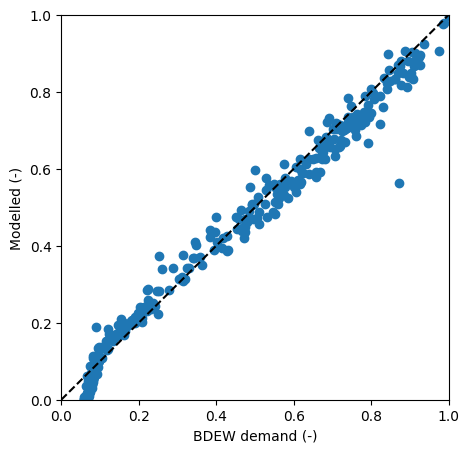

In [14]:
import matplotlib.pyplot as plt
comp_frame = plot_frame.loc[ot_daily_ref.index,]
comp_frame["BDEW"] = ot_daily_ref["daily"]/ot_daily_ref["daily"].max()
# px.scatter(x=comp_frame["BDEW"],y=comp_frame["ABM_agg_n=5000"], width=400, height=400)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(comp_frame["BDEW"], comp_frame["ABM_agg_n=500"], label="ABM_agg_n=500")
# ax.scatter(comp_frame["BDEW"], comp_frame["ABM_agg_n=5000"], label="ABM_agg_n=5000")
ax.set_xlabel("BDEW demand (-)")
ax.set_ylabel("Modelled (-)")
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0,1],[0,1], "--", color="black")

In [15]:
comp_frame.max()/comp_frame.mean()

hourly            2.486786
ABM_agg_n=500     2.551496
ABM_agg_n=5000    2.552033
BDEW              2.487225
dtype: float64

Text(0.5, 0, 'peak to mean ratio (-)')

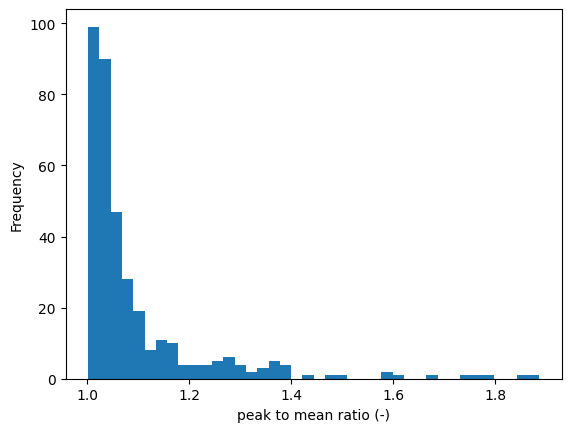

In [16]:
p2m_ratio = plot_frame.groupby(plot_frame.index.dayofyear).agg(["max","mean"])
ax = (p2m_ratio["ABM_agg_n=500"]["max"]/p2m_ratio["ABM_agg_n=500"]["mean"]).plot(kind="hist", bins=40)
ax.set_xlabel("peak to mean ratio (-)")

# exporting time series shapes

In [18]:
agg_heat_demands = [generate_agg_heat_demand(temps[col], n_random_samples=5000) for col in temps.columns]

In [20]:
canada_agg_demand_shapes = pd.concat(agg_heat_demands, axis=1)
canada_agg_demand_shapes.columns = temps.columns
canada_agg_demand_shapes

,Quebec,Newfoundland and Labrador,British Columbia,New Brunswick,Nova Scotia,Saskatchewan,Alberta,Prince Edward Island,Manitoba,Ontario,Canada
time,,,,,,,,,,,
2013-01-01 00:00:00,0.806836,0.830149,0.705685,0.814534,0.773521,0.809437,0.629637,0.796363,0.904993,0.829703,0.869879
2013-01-01 01:00:00,0.807693,0.828764,0.706090,0.815856,0.775858,0.805795,0.628494,0.797201,0.901400,0.829374,0.869284
2013-01-01 02:00:00,0.808679,0.828329,0.705819,0.817825,0.778013,0.802317,0.627071,0.797669,0.897692,0.830194,0.868807
2013-01-01 03:00:00,0.809013,0.827445,0.706233,0.820128,0.779941,0.799486,0.626098,0.798945,0.893538,0.829985,0.868042
2013-01-01 04:00:00,0.810404,0.826936,0.707047,0.822200,0.782584,0.796298,0.625115,0.799764,0.889383,0.830898,0.868021


In [21]:
canada_agg_demand_shapes.to_pickle("data/canada/timeseries/canada_agg_demand_shapes.pkl")